# Pipeline completo: PETR4.SA — Coleta de dados, Pré processamento, Modelo, Treino e Ajuste Hiperparâmetros

Este notebook reúne todas as funções presentes em `src/` numa única sequência executável:
- `Coleta de dados` — baixa via yfinance e salva CSV
- `Pré processamento` — carregamento, limpeza, criação de sequências multi-step e scaler
- `Modelo` — constrói LSTM many-to-many
- `Treino` — treina o modelo base e salva artefatos
- `Ajuste Hiperparâmetros` — configuração com KerasTuner (pronto para rodar se `keras-tuner` estiver instalado)
- Avaliação comparativa entre **modelo base** e **modelo tuneado**

In [9]:
# Imports e configurações
import os
import numpy as np
import pandas as pd
from pathlib import Path
import joblib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_absolute_error, mean_squared_error

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [10]:
# Data collection: função para baixar PETR4.SA via yfinance
def data_collection(symbol='PETR4.SA', start_date='2015-01-01', end_date=None, out_csv='data/PETR4.SA.csv', auto_adjust=False):
    Path('data').mkdir(parents=True, exist_ok=True)
    import yfinance as yf
    df = yf.download(symbol, start=start_date, end=end_date, progress=False, auto_adjust=auto_adjust)
    if df.empty:
        raise RuntimeError('No data downloaded — check symbol or network.')
    # select columns depending on presence
    cols = ['Open','High','Low','Close','Adj Close','Volume']
    cols_present = [c for c in cols if c in df.columns]
    df = df[cols_present]
    df.to_csv(out_csv)
    print(f"Saved {out_csv} — {len(df)} rows")
    return df


In [11]:
# Preprocess: carregamento, limpeza e criação de sequências multi-step
from sklearn.preprocessing import MinMaxScaler

def load_csv(path):
    return pd.read_csv(path, index_col=0, parse_dates=True)

def series_from_df(df, feature='Close'):
    if feature not in df.columns:
        raise KeyError(f"Coluna '{feature}' não encontrada. Colunas: {list(df.columns)}")
    s = df[feature].ffill()  # forward fill
    s_numeric = pd.to_numeric(s, errors='coerce')
    non_numeric = s[s_numeric.isna()]
    if len(non_numeric) > 0:
        print("Aviso: foram encontrados valores não numéricos/NaN na série (amostra):")
        print(non_numeric.head(10))
        print("Esses valores serão removidos antes da normalização.")
    s_clean = s_numeric.dropna()
    if s_clean.empty:
        raise ValueError('Série vazia após limpeza.')
    return s_clean.values.reshape(-1,1)

def create_multistep_sequences(series, seq_len=60, horizon=5, scaler=None):
    # series: np.ndarray (n,1) or pd.Series
    if isinstance(series, pd.Series) or isinstance(series, pd.DataFrame):
        series = series.values.reshape(-1,1)
    series = np.asarray(series, dtype=float)
    if scaler is None:
        scaler = MinMaxScaler()
        scaled = scaler.fit_transform(series)
    else:
        scaled = scaler.transform(series)
    X, y = [], []
    max_start = len(scaled) - seq_len - horizon + 1
    if max_start <= 0:
        raise ValueError(f"Série muito curta para seq_len={seq_len} e horizon={horizon}.")
    for i in range(max_start):
        X.append(scaled[i:i+seq_len,0])
        y.append(scaled[i+seq_len:i+seq_len+horizon,0])
    X = np.array(X).reshape(-1, seq_len, 1)
    y = np.array(y)
    return X, y, scaler

def temporal_train_val_test_split(X, y, train_ratio=0.7, val_ratio=0.15):
    n = len(X)
    train_end = int(n * train_ratio)
    val_end = train_end + int(n * val_ratio)
    X_train, y_train = X[:train_end], y[:train_end]
    X_val, y_val = X[train_end:val_end], y[train_end:val_end]
    X_test, y_test = X[val_end:], y[val_end:]
    return X_train, y_train, X_val, y_val, X_test, y_test

def save_scaler(scaler, path='models/scaler.save'):
    Path('models').mkdir(parents=True, exist_ok=True)
    joblib.dump(scaler, path)


In [12]:
# Model: build multistep LSTM
def build_multistep_lstm(seq_len=60, horizon=5, hidden_units=64, dropout=0.2):
    model = Sequential()
    model.add(Input(shape=(seq_len,1)))
    model.add(LSTM(hidden_units, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(hidden_units))
    model.add(Dropout(dropout))
    model.add(Dense(horizon, name='horizon_output'))
    model.compile(optimizer=Adam(1e-3), loss='mse', metrics=['mae'])
    return model


In [13]:
# Train pipeline (base model)
def train_pipeline(csv_path='data/PETR4.SA.csv', seq_len=60, horizon=5, epochs=30, batch_size=32, model_out='models/lstm_multistep.keras'):
    """
    Treina o modelo base (LSTM many-to-many), calcula MAE e RMSE por horizonte
    e salva o modelo e o scaler.
    Compatível com qualquer versão do sklearn (usa np.sqrt(mse) para RMSE).
    """
    # load and preprocess
    df = load_csv(csv_path)
    series = series_from_df(df, feature='Close')
    X, y, scaler = create_multistep_sequences(series, seq_len=seq_len, horizon=horizon)
    X_train, y_train, X_val, y_val, X_test, y_test = temporal_train_val_test_split(X, y)

    # build model (usa a função definida no notebook)
    model = build_multistep_lstm(seq_len=seq_len, horizon=horizon)

    # callbacks
    from tensorflow.keras.callbacks import EarlyStopping
    early = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

    # fit
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early],
        verbose=1
    )

    # predict & inverse scale
    preds = model.predict(X_test)
    preds_unscaled = scaler.inverse_transform(preds.reshape(-1,1)).reshape(preds.shape)
    y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1,1)).reshape(y_test.shape)

    # metrics per horizon (MAE and RMSE)
    maes, rmses = [], []
    for h in range(preds_unscaled.shape[1]):
        mae = mean_absolute_error(y_test_unscaled[:,h], preds_unscaled[:,h])
        mse = mean_squared_error(y_test_unscaled[:,h], preds_unscaled[:,h])
        rmse = float(np.sqrt(mse))
        maes.append(float(mae))
        rmses.append(rmse)

    # save artifacts
    Path('models').mkdir(parents=True, exist_ok=True)
    model.save(model_out)
    save_scaler(scaler, path='models/scaler.save')
    print(f'Saved model to {model_out}')
    return model, history, (maes, rmses), (X_test, y_test, preds_unscaled)


In [ ]:
# Hyperparameter tuning with KerasTuner
def tune_with_keras_tuner(csv_path='data/PETR4.SA.csv', seq_len=60, horizon=5, max_trials=10, executions_per_trial=1, tuner_dir='kt_dir', project_name='kt_lstm'):
    try:
        import keras_tuner as kt
    except Exception:
        raise RuntimeError('Install keras-tuner: pip install keras-tuner')
    # get data
    df = load_csv(csv_path)
    series = series_from_df(df, feature='Close')
    X, y, scaler = create_multistep_sequences(series, seq_len=seq_len, horizon=horizon)
    X_train, y_train, X_val, y_val, X_test, y_test = temporal_train_val_test_split(X, y)
    # model builder
    def builder(hp):
        from tensorflow.keras.models import Sequential
        from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
        model = Sequential()
        model.add(Input(shape=(seq_len,1)))
        n_layers = hp.Choice('n_lstm_layers', [1,2], default=2)
        for i in range(n_layers):
            units = hp.Int(f'lstm_units_{i}', 32, 256, step=32, default=64)
            return_seq = True if (i < n_layers-1) else False
            model.add(LSTM(units, return_sequences=return_seq))
            model.add(Dropout(hp.Float(f'dropout_{i}', 0.0, 0.5, step=0.1, default=0.2)))
        if hp.Boolean('use_dense', default=True):
            dense_units = hp.Int('dense_units', 8, 128, step=8, default=32)
            model.add(Dense(dense_units, activation='relu'))
        model.add(Dense(horizon))
        lr = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log', default=1e-3)
        model.compile(optimizer=Adam(learning_rate=lr), loss='mse', metrics=['mae'])
        return model
    tuner = kt.BayesianOptimization(
        builder,
        objective='val_loss',
        max_trials=max_trials,
        executions_per_trial=executions_per_trial,
        directory=tuner_dir,
        project_name=project_name,
        overwrite=True
    )
    from tensorflow.keras.callbacks import EarlyStopping
    tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=50, callbacks=[EarlyStopping(monitor='val_loss', patience=7)], verbose=1)
    best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_model = tuner.get_best_models(num_models=1)[0]
    # save best
    Path('models').mkdir(parents=True, exist_ok=True)
    best_model.save('models/lstm_multistep_tuned.keras')
    save_scaler(scaler, path='models/scaler.save')
    # evaluate on test
    preds = best_model.predict(X_test)
    preds_unscaled = scaler.inverse_transform(preds.reshape(-1,1)).reshape(preds.shape)
    y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1,1)).reshape(y_test.shape)
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    maes, rmses = [], []
    for h in range(preds_unscaled.shape[1]):
        maes.append(float(mean_absolute_error(y_test_unscaled[:,h], preds_unscaled[:,h])))
        rmses.append(float(mean_squared_error(y_test_unscaled[:,h], preds_unscaled[:,h], squared=False)))
    # save hp
    import json
    with open('models/best_hyperparameters.json','w') as f:
        json.dump(best_hp.values, f, indent=2)
    return best_model, best_hp, (maes, rmses), (X_test, y_test, preds_unscaled)


In [15]:
# Comparativo de métricas entre modelo base e modelo tuneado
def compare_metrics(base_metrics, tuned_metrics, horizons=None):
    # base_metrics and tuned_metrics are tuples (maes, rmses)
    base_mae, base_rmse = base_metrics
    tun_mae, tun_rmse = tuned_metrics
    if horizons is None:
        horizons = [f't+{i+1}' for i in range(len(base_mae))]
    import pandas as pd
    df = pd.DataFrame({
        'horizon': horizons,
        'base_mae': base_mae,
        'tuned_mae': tun_mae,
        'base_rmse': base_rmse,
        'tuned_rmse': tun_rmse
    })
    display(df)
    # simple plots
    plt.figure(figsize=(10,4))
    plt.plot(horizons, base_mae, marker='o', label='base MAE')
    plt.plot(horizons, tun_mae, marker='o', label='tuned MAE')
    plt.title('MAE por horizonte')
    plt.legend()
    plt.show()
    plt.figure(figsize=(10,4))
    plt.plot(horizons, base_rmse, marker='o', label='base RMSE')
    plt.plot(horizons, tun_rmse, marker='o', label='tuned RMSE')
    plt.title('RMSE por horizonte')
    plt.legend()
    plt.show()


### Etapa que chama as funções

In [ ]:
#Download dos dados
from pathlib import Path
Path('data').mkdir(parents=True, exist_ok=True)

csv_path = "data/PETR4.SA.csv"
if not Path(csv_path).exists():
    print("Arquivo CSV não encontrado — baixando via yfinance...")
    df = data_collection('PETR4.SA', start_date='2015-01-01', end_date='2024-12-31', out_csv=csv_path)
else:
    print("CSV já existe:", csv_path)
    df = load_csv(csv_path)

print("Linhas do CSV:", len(df))
display(df.head())

CSV já existe: data/PETR4.SA.csv
Linhas do CSV: 2489


C:\Users\erick\AppData\Local\Temp\ipykernel_14404\2070847896.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return pd.read_csv(path, index_col=0, parse_dates=True)


,Open,High,Low,Close,Volume
Price,,,,,
Ticker,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA
Date,NaN,NaN,NaN,NaN,NaN
2015-01-02,2.745659244726361,2.745659244726361,2.569761318693598,2.572509527206421,49559500
2015-01-05,2.5120441653627923,2.525785991075337,2.3443911657410967,2.3526365756988525,78385100
2015-01-06,2.3938628595012226,2.4268437168980266,2.209719542454317,2.275681257247925,84723300


In [26]:
# === Preparação + Pré-processamento ===
from pathlib import Path
import pandas as pd
import numpy as np

Path('data').mkdir(parents=True, exist_ok=True)
raw_csv = "data/PETR4.SA.csv"
proc_csv = "data/PETR4.SA.processed.csv"

if not Path(raw_csv).exists():
    raise FileNotFoundError(f"{raw_csv} não encontrado. Rode a célula de coleta antes.")

# 1) ler CSV sem forçar índice
df_raw = pd.read_csv(raw_csv, header=0)
print("Colunas originais:", list(df_raw.columns))
display(df_raw.head())

# 2) remover coluna Price se existir (artifact)
if 'Price' in df_raw.columns:
    df_raw = df_raw.drop(columns=['Price'])
    print("Coluna 'Price' removida.")

# 3) Função robusta para converter strings numéricas (milhares e vírgulas)
def convert_str_to_float(v):
    if pd.isna(v): 
        return np.nan
    if isinstance(v, (int,float)):
        return float(v)
    s = str(v).strip()
    # remove common extraneous chars
    s = s.replace('R$', '').replace(' ', '')
    # if both '.' and ',' exist, assume '.' thousand sep and ',' decimal -> remove dots then replace comma
    if '.' in s and ',' in s:
        s = s.replace('.', '').replace(',', '.')
    else:
        s = s.replace(',', '.')
    # remove any remaining non numeric characters
    allowed = set('0123456789.-')
    s = ''.join(ch for ch in s if ch in allowed)
    try:
        return float(s)
    except:
        return np.nan

# 4) Aplicar conversão nas colunas de interesse
cols_expected = ['Open','High','Low','Close','Volume']
for c in cols_expected:
    if c in df_raw.columns:
        df_raw[c] = df_raw[c].apply(convert_str_to_float)

# 5) Se houver coluna Date / Data, tentar convertê-la e definir índice
# tenta encontrar coluna de data
date_col = None
for c in df_raw.columns:
    if 'date' in c.lower() or 'data' in c.lower():
        date_col = c
        break
# se não encontrou, ver se o primeiro header parece data ao converter (tentar)
if date_col is None:
    first_col = df_raw.columns[0]
    # se não for numeric, talvez seja data
    if df_raw[first_col].dtype == object:
        try:
            parsed = pd.to_datetime(df_raw[first_col], errors='coerce', dayfirst=False)
            if parsed.notna().sum() > len(df_raw)*0.5:
                date_col = first_col
        except:
            date_col = None

if date_col:
    df_raw[date_col] = pd.to_datetime(df_raw[date_col], errors='coerce', infer_datetime_format=True)
    df_proc = df_raw.dropna(subset=[date_col])
    df_proc = df_proc.set_index(date_col).sort_index()
    print("Usando coluna de datas:", date_col)
else:
    # fallback: manter df as-is but index range
    df_proc = df_raw.copy()
    print("Nenhuma coluna de datas detectada com confiança — mantendo índice padrão.")

# 6) drop linhas sem Close
if 'Close' in df_proc.columns:
    before = len(df_proc)
    df_proc = df_proc.dropna(subset=['Close'])
    print(f"Removidas {before - len(df_proc)} linhas sem Close.")
else:
    raise KeyError("Coluna 'Close' não encontrada após processamento — verifique CSV.")

# 7) salvar CSV processado
df_proc.to_csv(proc_csv, index=True)
print("CSV processado salvo em:", proc_csv)
display(df_proc.head())


Colunas originais: ['Price', 'Open', 'High', 'Low', 'Close', 'Volume']


,Price,Open,High,Low,Close,Volume
0,Ticker,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA
1,Date,NaN,NaN,NaN,NaN,NaN
2,2015-01-02,2.745659244726361,2.745659244726361,2.569761318693598,2.572509527206421,49559500
3,2015-01-05,2.5120441653627923,2.525785991075337,2.3443911657410967,2.3526365756988525,78385100
4,2015-01-06,2.3938628595012226,2.4268437168980266,2.209719542454317,2.275681257247925,84723300


Coluna 'Price' removida.
Nenhuma coluna de datas detectada com confiança — mantendo índice padrão.
Removidas 1 linhas sem Close.
CSV processado salvo em: data/PETR4.SA.processed.csv


,Open,High,Low,Close,Volume
0,4.000000,4.000000,4.000000,4.000000,4.0
2,2.745659,2.745659,2.569761,2.572510,49559500.0
3,2.512044,2.525786,2.344391,2.352637,78385100.0
4,2.393863,2.426844,2.209720,2.275681,84723300.0
5,2.352637,2.399359,2.297668,2.382869,85531000.0



Colunas encontradas: ['Open', 'High', 'Low', 'Close', 'Volume']

Tipos das colunas após conversão:
Open      float64
High      float64
Low       float64
Close     float64
Volume    float64
dtype: object

=== Estatísticas básicas ===


,count,mean,std,min,25%,50%,75%,max
Open,2488.0,1.038534e+01,8.826970e+00,1.154331,4.176892e+00,7.306889e+00,1.326792e+01,3.462425e+01
High,2488.0,1.052887e+01,8.915934e+00,1.173570,4.251786e+00,7.411559e+00,1.352229e+01,3.497607e+01
Low,2488.0,1.024014e+01,8.744646e+00,1.132344,4.116427e+00,7.199725e+00,1.302276e+01,3.441831e+01
Close,2488.0,1.038396e+01,8.832484e+00,1.154331,4.172083e+00,7.314075e+00,1.332915e+01,3.483019e+01
Volume,2488.0,5.995797e+07,3.327329e+07,0.000000,3.842178e+07,5.295300e+07,7.285408e+07,4.902304e+08



=== Correlação com CLOSE ===


,corr_Close
Close,1.000000
Low,0.999864
High,0.999850
Open,0.999675
Volume,-0.132684


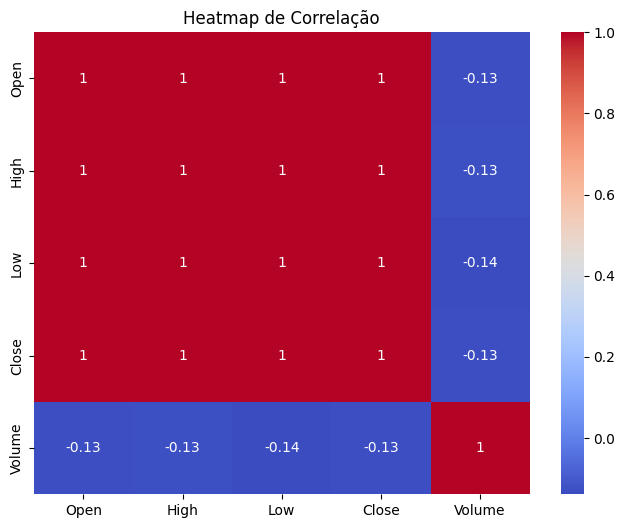

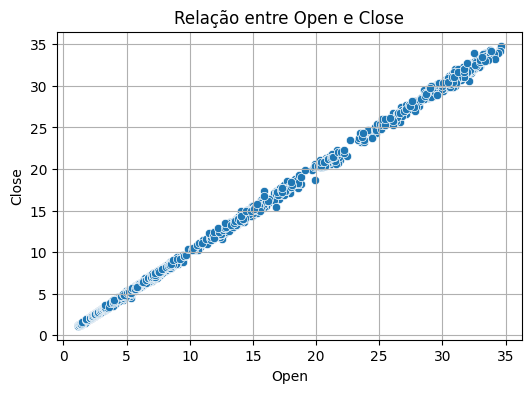

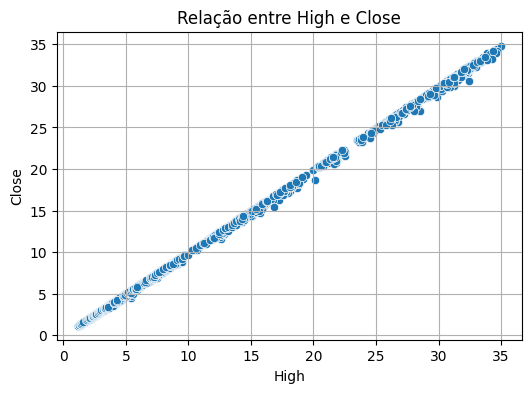

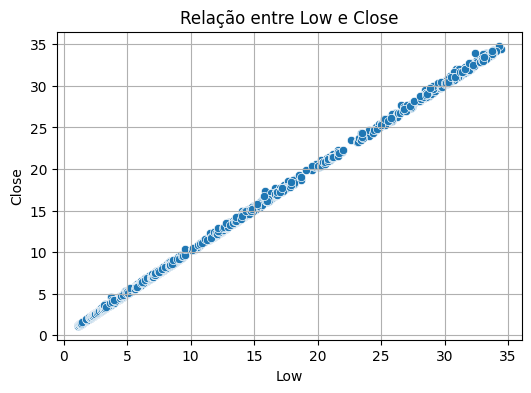

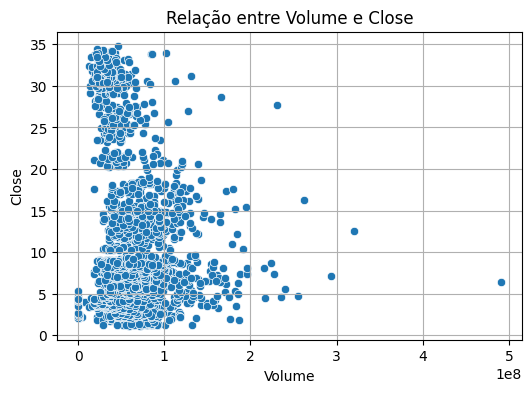

In [27]:
# ============================
# Carregar CSV corretamente
# ============================
df = df_proc

print("\nColunas encontradas:", list(df.columns))

# ============================
# Função robusta para converter strings numéricas
# ============================
def convert_str_to_float(s):
    if isinstance(s, str):
        s = s.strip()
        # remover separadores de milhar
        s = s.replace(".", "")
        # trocar vírgula por ponto
        s = s.replace(",", ".")
        # remover símbolos estranhos
        s = s.replace("R$", "").replace(" ", "")
        try:
            return float(s)
        except:
            return np.nan
    return s

# ============================
# Converter colunas numéricas
# ============================
numeric_cols = ["Open", "High", "Low", "Close", "Volume"]

for col in numeric_cols:
    if col in df.columns:
        df[col] = df[col].apply(convert_str_to_float)

print("\nTipos das colunas após conversão:")
print(df.dtypes)

# ============================
# Remover linhas sem Close
# ============================
df = df.dropna(subset=["Close"])


# ============================
# Estatísticas básicas
# ============================
print("\n=== Estatísticas básicas ===")
display(df[numeric_cols].describe().T)

# ============================
# Correlação com a variável alvo (Close)
# ============================
print("\n=== Correlação com CLOSE ===")
corr = df[numeric_cols].corr()["Close"].sort_values(ascending=False)
display(corr.to_frame("corr_Close"))

# ============================
# Heatmap de correlação
# ============================
plt.figure(figsize=(8,6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Heatmap de Correlação")
plt.show()

# ============================
# Scatterplots entre Close e outras
# ============================
features = [c for c in numeric_cols if c != "Close"]

for f in features:
    plt.figure(figsize=(6,4))
    sns.scatterplot(data=df, x=f, y="Close")
    plt.title(f"Relação entre {f} e Close")
    plt.grid(True)
    plt.show()


Aviso: foram encontrados valores não numéricos/NaN na série (amostra):
Price
Ticker    PETR4.SA
Date      PETR4.SA
Name: Close, dtype: object
Esses valores serão removidos antes da normalização.
Epoch 1/30


C:\Users\erick\AppData\Local\Temp\ipykernel_14404\2070847896.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return pd.read_csv(path, index_col=0, parse_dates=True)


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0023 - mae: 0.0338 - val_loss: 0.0016 - val_mae: 0.0310
Epoch 2/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.4739e-04 - mae: 0.0184 - val_loss: 0.0025 - val_mae: 0.0407
Epoch 3/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.5720e-04 - mae: 0.0169 - val_loss: 0.0023 - val_mae: 0.0385
Epoch 4/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.4489e-04 - mae: 0.0167 - val_loss: 0.0012 - val_mae: 0.0259
Epoch 5/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.5503e-04 - mae: 0.0149 - val_loss: 0.0015 - val_mae: 0.0302
Epoch 6/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.2263e-04 - mae: 0.0146 - val_loss: 0.0010 - val_mae: 0.0246
Epoch 7/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.7875e-04 - mae: 0.0136 - val_loss: 0.0011 - val_mae: 0.0254
Epoch 8/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.5751e-04 - mae: 0.0132 - val_loss: 9.4494e-04 - val_mae: 0.0235
Epoch 9/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 15

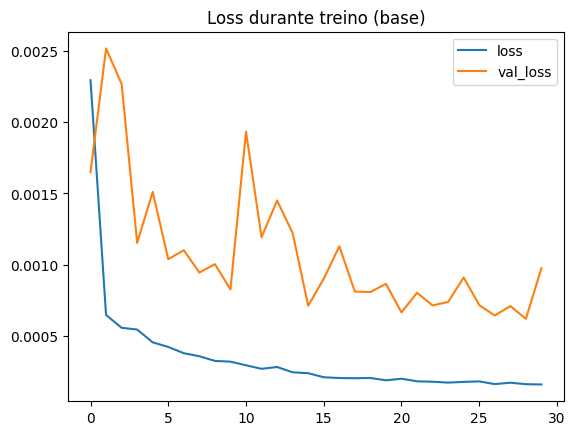

In [ ]:
# Treino do modelo
epochs_test = 30
model_base, history_base, metrics_base, data_base = train_pipeline(csv_path='data/PETR4.SA.processed.csv',
                                                                    seq_len=60, horizon=5,
                                                                    epochs=epochs_test, batch_size=32,
                                                                    model_out='models/lstm_multistep_test.keras')
print("Métricas (base) MAE por horizon:", metrics_base[0])
print("Métricas (base) RMSE por horizon:", metrics_base[1])
# Mostra curvas de treino/validação
import matplotlib.pyplot as plt
plt.plot(history_base.history['loss'], label='loss')
if 'val_loss' in history_base.history:
    plt.plot(history_base.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss durante treino (base)')
plt.show()

In [ ]:
# Tune do modelo
do_tune = True  # coloque False se não quiser rodar tuning agora
if do_tune:
    try:
        best_model, best_hp, metrics_tuned, data_tuned = tune_with_keras_tuner(
            csv_path='data/PETR4.SA.processed.csv',
            seq_len=60,
            horizon=5,
            max_trials= 10,            
            executions_per_trial=1,
            tuner_dir='kt_dir_test',
            project_name='kt_test'
        )
        print("Melhor HP:", best_hp.values)
        print("Métricas (tune) MAE por horizon:", metrics_tuned[0])
        print("Métricas (tune) RMSE por horizon:", metrics_tuned[1])
    except Exception as e:
        print("Erro ao rodar tuning:", e)
        raise
else:
    print("Tuning pulado (do_tune=False)")

Trial 10 Complete [00h 01m 33s]
val_loss: 0.00043023659964092076

Best val_loss So Far: 0.00043023659964092076
Total elapsed time: 00h 13m 22s
 1/12 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step

c:\Users\erick\Documents\FIAP\TC\FASE4_TC\venv\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Melhor HP: {'n_lstm_layers': 1, 'lstm_units_0': 224, 'dropout_0': 0.30000000000000004, 'lstm_units_1': 64, 'dropout_1': 0.4, 'use_dense': False, 'dense_units': 72, 'learning_rate': 0.006820026103064649}
Métricas (tune) MAE por horizon: [0.4498863796611412, 0.7822184091085919, 0.7615256204709905, 0.888008840791472, 0.9130958829607285]
Métricas (tune) RMSE por horizon: [0.5840850081416754, 0.9471571821810578, 0.9708233613905446, 1.123098837403265, 1.1608194661736286]


,horizon,base_mae,tuned_mae,base_rmse,tuned_rmse
0,t+1,0.556688,0.449886,0.732880,0.584085
1,t+2,0.741549,0.782218,0.951738,0.947157
2,t+3,1.164918,0.761526,1.384946,0.970823
3,t+4,1.288690,0.888009,1.521195,1.123099
4,t+5,1.387274,0.913096,1.639977,1.160819


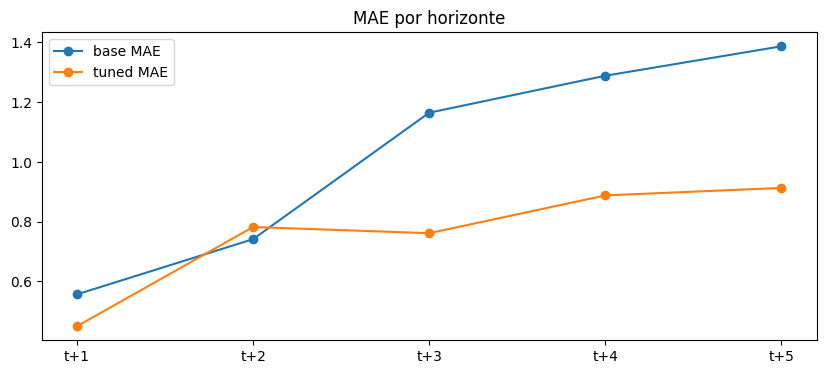

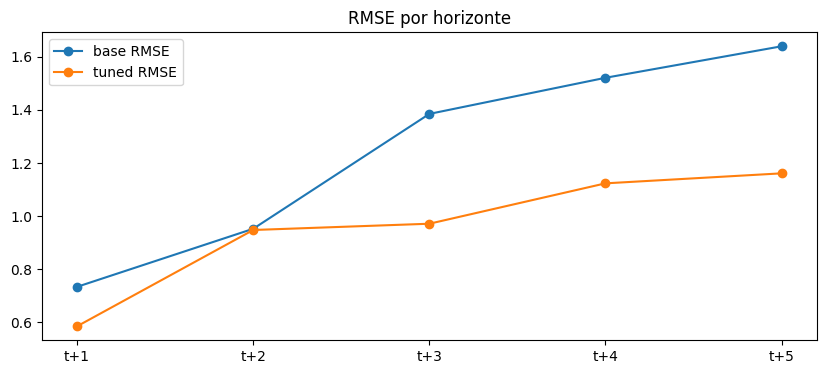

In [22]:
# Compara as métricas do modelo
try:
    compare_metrics(metrics_base, metrics_tuned)
except NameError:
    print("Variáveis não encontradas")

In [25]:
import joblib, numpy as np
from tensorflow.keras.models import load_model

# escolha o modelo (o treino de teste salvou 'lstm_multistep_test.keras'; tuning salva 'lstm_multistep_tuned.keras')
model_path = "models/lstm_multistep_tuned.keras" 
scaler_path = "models/scaler.save"
print("Usando modelo:", model_path)
print("Scaler existe:", Path(scaler_path).exists())

if model_path is not None and Path(scaler_path).exists():
    model_inf = load_model(model_path, compile=False)
    scaler = joblib.load(scaler_path)
    df = load_csv('data/PETR4.SA.csv')
    series = series_from_df(df, feature='Close')
    recent = series[-60:].reshape(-1,1)
    scaled = scaler.transform(recent)
    inp = scaled.reshape(1,60,1)
    pred_scaled = model_inf.predict(inp)
    pred = scaler.inverse_transform(pred_scaled.reshape(-1,1)).reshape(pred_scaled.shape)[0]
    print("Predicted (t+1..t+5):", pred.tolist())
else:
    print("Modelo ou scaler não encontrados.")

Usando modelo: models/lstm_multistep_tuned.keras
Scaler existe: True
Aviso: foram encontrados valores não numéricos/NaN na série (amostra):
Price
Ticker    PETR4.SA
Date      PETR4.SA
Name: Close, dtype: object
Esses valores serão removidos antes da normalização.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Predicted (t+1..t+5): [32.9077262878418, 32.596923828125, 32.75149917602539, 32.75144958496094, 32.865745544433594]


C:\Users\erick\AppData\Local\Temp\ipykernel_14404\2070847896.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return pd.read_csv(path, index_col=0, parse_dates=True)
